In [1]:
# Bibliotecas necessárias para o experimento

import numpy as np, numpy.random
import matplotlib.pyplot as plt
from random import randint
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from random import randint, uniform, random
from scipy.linalg import sqrtm

In [2]:
## CONSTANTES PARA O ALGORITMO GENÉTICO

ELITISMO = True
PORCENTAGEM_ELITISMO = 0.20

TAMANHO_POP = 50
TAXA_MUTACAO = 0.10
TAXA_CRUZAMENTO = 0.70
GERACOES = 100

# Valores mínimos e máximos para gerar uma população
MIN = 0
MAX = 200
 # 115, 150

In [3]:
def S(Ut, Uf, X):
    W = np.dot(np.transpose(Uf), Ut)
    T = np.transpose(W)
    A = np.dot(np.transpose(Ut), np.transpose(X))
    C = np.dot(A, Uf)
    L = W - np.identity(3) - 1/2*(W - np.identity(3))**2
    S = 2*np.trace(np.dot((-np.dot(T, C) + 2*C),L))
    #S = 2*np.trace(np.dot((-1/2*np.dot(C, T) - 1/2*np.dot(T, C) + 2*C),L))
    return S

In [4]:
def field(Ut, Uf, a, h, A, B):
    SA = S(Ut, Uf, A)
    SB = S(Ut, Uf, B)
    f = -a*SA-h*(SB/SA)
    return f

In [5]:
def lind(u, Ut, Uf, t, lbda):
    n = 1
    Ax = [[0, 0, 0],[0, 0, -1], [0, 1, 0]]
    Ay = [[0, 0, 1],[0, 0, 0], [-1, 0, 0]]
    Az = [[0, -1, 0],[1, 0, 0], [0, 0, 0]]
    B = [[(1-n*2)*lbda, 0, 0],[0, (1-n*2)*lbda, 0], [0, 0, (-n*2)*lbda]] # Amplitude Damping
    #B = [[-1.01*lbda, 0, 0],[0, -1.01*lbda, 0], [0, 0, -0.01*lbda]] # Phase Damping
    if t == 0:
        fx = u[0]
        fy = u[1]
        fz = u[2]
        F=np.dot(u[0],Ax)+np.dot(u[1],Ay)+np.dot(u[2],Az)+B
    else:
        fx=field(Ut, Uf, u[0], 0.35, Ax, B)
        fy=field(Ut, Uf, u[1], 0.31, Ay, B)
        fz=field(Ut, Uf, u[2], 0.34, Az, B)
        P=400

        if abs(fx) > P:
            if fx < 0:
                fx = -P
            else:
                fx = P
        if abs(fy) > P:
            if fy < 0:
                fy = -P
            else:
                fy = P
        if abs(fz) > P:
            if fz < 0:
                fz = -P
            else:
                fz = P

        F=np.dot(fx,Ax)+np.dot(fy,Ay)+np.dot(fz,Az)+B
        	
    return fx,fy,fz,F

In [6]:
def rungeKutta(u, Ut, Uf, h, t, lbda):

    if t == 0:
        
        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    else:

        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t+h/2, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t+h/2, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t+h, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    
    result = Ut+(h/6)*(k1+2*k2+2*k3+k4);
    return a,b,c,result

In [7]:
def func_objetivo(u, Ut, Uf, h, tempo, lbda):
    a, b, c, Ut1 = rungeKutta(u, Ut, Uf, h, tempo, lbda)
    return (np.linalg.norm(Ut1-Uf))**2

In [8]:
def gerar_populacao():
    populacao = np.zeros((TAMANHO_POP,3))
    for individuo in range(TAMANHO_POP):
        for genes in range(3):
            populacao[individuo,genes] = uniform(MIN, MAX)
    return populacao

In [9]:
def calcular_func(populacao, Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    valor_func = np.zeros(TAMANHO_POP)
    for individuo in range(TAMANHO_POP):
        valor_func[individuo] = func_objetivo(populacao[individuo,:], Ut, Uf, h, tempo, lbda)
    return valor_func

In [10]:
def selecao(valor_fitness):
    pos = np.random.choice(range(TAMANHO_POP), 2, replace=False)
    valor = valor_fitness[pos[0]] < valor_fitness[pos[1]]
    if valor == True:
        return pos[0]
    else:
        return pos[1]

In [11]:
def divisao_fitness(valor_funcao_objetivo):
    divisao = 0
    for i in range(len(valor_funcao_objetivo)):
        divisao += valor_funcao_objetivo[i]
    return divisao

def fitness(valor_funca_objetivo):
    return valor_funca_objetivo/divisao_fitness(valor_funca_objetivo)

In [12]:
def cruzamento(pai1, pai2):
    x = random()
    filho1 = x*pai1+(1-x)*pai2
    filho2 = (1-x)*pai1+x*pai2
    return filho1, filho2

In [13]:
def mutacao(individuo, horizonte):
    
    # Gaussian function
    for i in range (0, horizonte):
        if random() < TAXA_MUTACAO:
            individuo[i] = (1/np.sqrt(2*np.pi))*np.exp((-1/2*(uniform(MIN, MAX)-2)**2))
    
    return individuo

In [14]:
def genetico(Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    
    horizonte = 3
    pop = gerar_populacao()
    fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
    fit = fitness(fo)
    fit_edit = fit
    min_fit = min(fit)
            
    melhor_fo = np.zeros(GERACOES)
    for geracao in range(GERACOES):
        new_pop = np.empty((0, horizonte))
        for i in range(round((TAMANHO_POP)/2)):
            pai1 = 0
            pai2 = 0
            while pai1 == pai2:
                pai1 = selecao(fit)
                pai2 = selecao(fit)
            if random() < TAXA_CRUZAMENTO:
                filho1, filho2 = cruzamento(pop[pai1, :], pop[pai2, :])
                filho1 = mutacao(filho1, horizonte)
                filho2 = mutacao(filho2, horizonte)
                new_pop = np.vstack([new_pop, filho1, filho2])
            else:
                pais = np.vstack([mutacao(pop[pai1, :], horizonte), mutacao(pop[pai2, :], horizonte)])
                new_pop = np.vstack([new_pop, pais])

        pop = new_pop
        fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
        fit = fitness(fo)
        min_fo = min(fo)
        melhor_fo[geracao] = min_fo
        pos_min_fo = np.where(fo == min_fo)
                
    return pop[pos_min_fo,:][0,0]

In [15]:
def leis_controle(fx, fy, fz, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    plt.ylabel("Valores das leis de controle") 
    plt.xlabel('Tempo (u. a.)') 
    plt.plot(ts, fx, color='g', marker='o', linewidth=1, markersize=1, label="$f_x(t)$")
    plt.plot(ts, fy, color='b', marker='_', linewidth=1, markersize=1, label="$f_y(t)$")
    plt.plot(ts, fz, color='r', marker='.', linewidth=1, markersize=1, label="$f_z(t)$")
    plt.legend(loc="upper right")
    plt.title(fr"Leis de controle para $\gamma = {lbda}$")
    plt.show()

In [16]:
def fidelidade(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de fidelidade") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Fidelidade com $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [17]:
def distance(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de distância") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Distância entre os operadores de evolução com $\gamma = {lbda}$")

    #x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    #axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    #axins.set_xlim(0.009, 0.020)
    #axins.set_ylim(0.98, 1)

    #axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    #ax.indicate_inset_zoom(axins)
    
    plt.show()

In [18]:
def densidade(rho, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel('Valores da matriz de densidade') 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    ax.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    ax.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    ax.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Evolução da matriz de densidade $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(max(abs(rho[0])), max(abs(rho[1])), max(abs(rho[2])), max(abs(rho[3])))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    axins.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    axins.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    axins.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")

    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [19]:
def main():
    r = 1
    aas = []
    u = [70, 106, 66, 0.35, 0.31, 0.34] # Hadamard
    
    Ut = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    Uf = [[0, 0, 1], [0, -1, 0], [1, 0, 0]] # Hadamard
    
    r0 = [[1], [0], [0]]
    rf = np.dot(Uf, r0)
    pf = [[1/2*(1+rf[2][0]), 1/2*(rf[0][0]-1j*rf[1][0])], [1/2*(rf[0][0]+1j*rf[1][0]), 1/2*(1-rf[2][0])]]
    
    h=0.001
    t=0
    i=0
    lbda=0.01
    # Proposta do algoritmo genético
    resultado_algoritmo_genetico = genetico(Ut, Uf, h, t, TAMANHO_POP, lbda) 
    u[0] = resultado_algoritmo_genetico[0]
    u[1] = resultado_algoritmo_genetico[1]
    u[2] = resultado_algoritmo_genetico[2]
    aas.append((u[0],u[1],u[2]))
    distance_vector = []
    fx_vector = []
    fy_vector = []
    fz_vector = []
    rho_vector = np.zeros((4,1000),dtype=np.complex128)
    fid_vector = []
    fid_autores = []
       
    while t < 100:

        if t < 8:
            a,b,c,Uto = rungeKutta(u, Ut, Uf, h, t, lbda)
            D = np.linalg.norm(Uto-Uf)**2
            distance_vector.append(D)
            fx_vector.append(a)
            fy_vector.append(b)
            fz_vector.append(c)
            rt = np.dot(Uto, r0)
            pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
            rho_vector[0][t] = pt[0][0]
            rho_vector[1][t] = pt[0][1]
            rho_vector[2][t] = pt[1][0]
            rho_vector[3][t] = pt[1][1]
            fid_vector.append((np.trace(sqrtm(sqrtm(pt) @ pf @ sqrtm(pt))))**2)
            fid_autores.append((np.trace(np.dot(Uto, np.transpose(Uto)))+np.abs(np.trace(np.dot(np.transpose(Uf), Uto)))**2)/(3*(3+1)))
            resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
            u[0] = resultado_algoritmo_genetico[0]
            u[1] = resultado_algoritmo_genetico[1]
            u[2] = resultado_algoritmo_genetico[2]
            aas.append((u[0],u[1],u[2]))
            print(f"Distância: {distance_vector[-1]}")
            print(f"Fidelidade: {fid_vector[-1]}")
            print(f"Fidelidade da porta: {fid_autores[-1]}")
            t += 1
            Ut = Uto
        else:
            h = 0.0005
            a,b,c,Uto = rungeKutta(u, Ut, Uf, h, t, lbda)
            D = np.linalg.norm(Uto-Uf)**2
            distance_vector.append(D)
            fx_vector.append(a)
            fy_vector.append(b)
            fz_vector.append(c)
            rt = np.dot(Uto, r0)
            pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
            if isinstance(t, float):
                rho_vector[0][int(round(t,0))+r] = pt[0][0]
                rho_vector[1][int(round(t,0))+r] = pt[0][1]
                rho_vector[2][int(round(t,0))+r] = pt[1][0]
                rho_vector[3][int(round(t,0))+r] = pt[1][1]
                r += 1
            fid_vector.append((np.trace(sqrtm(sqrtm(pt) @ pf @ sqrtm(pt))))**2)
            fid_autores.append((np.trace(np.dot(Uto, np.transpose(Uto)))+np.abs(np.trace(np.dot(np.transpose(Uf), Uto)))**2)/(3*(3+1)))
            resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
            u[0] = resultado_algoritmo_genetico[0]
            u[1] = resultado_algoritmo_genetico[1]
            u[2] = resultado_algoritmo_genetico[2]
            aas.append((u[0],u[1],u[2]))
        
            print(f"Distância: {distance_vector[-1]}")
            print(f"Fidelidade: {fid_vector[-1]}")
            print(f"Fidelidade da porta: {fid_autores[-1]}")
            t += 0.5
            Ut = Uto
        

    print(f"O rho gerado foi: {pt}") 
    print(f"A matriz de evolução Ut gerada foi: {Ut}")
    print(f"Portanto, a distância gerada foi: {D}")
    rt = np.dot(Ut, r0)
    pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
    
    #leis_controle(fx_vector,fy_vector,fz_vector,t,lbda)
    #densidade(rho_vector,t,lbda)
    #fidelidade(fid_vector,t,lbda)
    #fidelidade(fid_autores,t,lbda)
    #distance(distance_vector,t,lbda)

    return fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector, aas

In [20]:
import matplotlib.pyplot as plt

def histograma(componente, valores_as):

    valores = []
    # Extração dos valores para o componente escolhido
    valores_intermediarios = [sublista for sublista in a]
    for i in valores_intermediarios:
        valores.append(i[componente])
    
    # Criação do histograma
    plt.hist(valores, bins=10, edgecolor='black')
    plt.xlabel(f'Componente {["x", "y", "z"][componente]}')
    plt.ylabel('Frequência')
    plt.title(f'Histograma do Componente {["x", "y", "z"][componente]}')
    plt.show()


Começará a função principal
Distância: 7.933405621187693
Fidelidade: (0.5041179021722494-9.910064476602485e-10j)
Fidelidade da porta: 0.3278759689095414
Distância: 6.931004749685613
Fidelidade: (0.5691888532415437+2.204973567065118e-09j)
Fidelidade da porta: 0.2680116474352667
Distância: 5.016892803247712
Fidelidade: (0.6865099902527603+2.4870792170515303e-09j)
Fidelidade da porta: 0.2698889572891087
Distância: 2.7869081756918925
Fidelidade: (0.8257537241440002-9.880892430388339e-09j)
Fidelidade da porta: 0.46444474283535575
Distância: 0.9509153007939031
Fidelidade: (0.9397020046100781-5.73442358735089e-10j)
Fidelidade da porta: 0.7799364880990959
Distância: 0.22588421841099593
Fidelidade: (0.9862260315838965+2.7647755879011678e-09j)
Fidelidade da porta: 0.9461779129280558
Distância: 0.07141338410193929
Fidelidade: (0.9955901605780471-6.008486977544182e-10j)
Fidelidade da porta: 0.9840816536618003
Distância: 0.020869439845721195
Fidelidade: (0.9990115669689608+3.291325432730908e-10j)
F

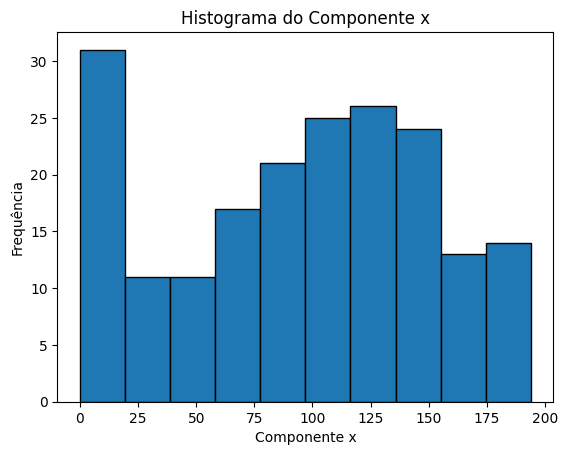

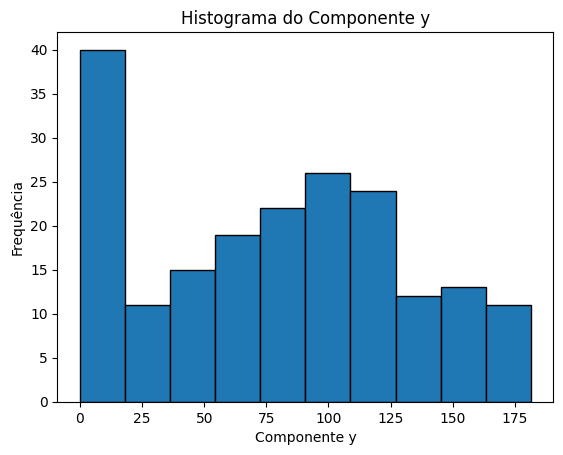

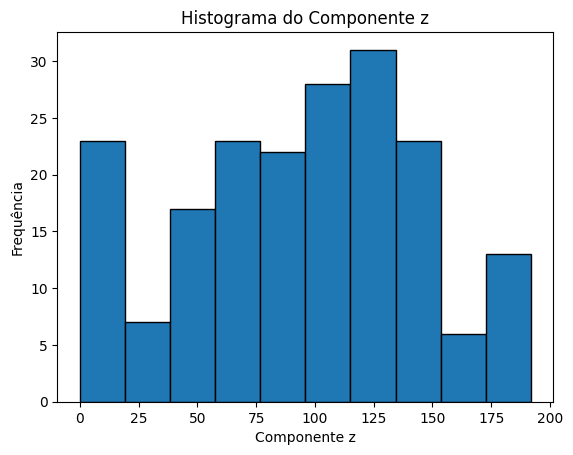

Terminou o histograma
Valores de média na iteração 1:
Portas: 0.9994832343851453
Estados: (0.9994252220700941+1.0290562676181723e-11j)
Distância: 3.0677883108783514e-06
 


In [21]:
portas = []
estados = []
distancia = []
i = 1

print(f"Começará a função principal")
fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector, a = main()
print(f"Terminou a função principal")
print(f"Veja o log: (Dos estados)")
print(fid_vector)
print(f"Veja o log: (Das portas)")
print(fid_autores)

portas.append(fid_autores[-1])
estados.append(fid_vector[-1])
distancia.append(distance_vector[-1])

print(f"Começou o histograma")
histograma(0, a)
histograma(1, a)
histograma(2, a)
print(f"Terminou o histograma")

print(f"Valores de média na iteração {i}:")
print(f"Portas: {sum(portas)/i}")
print(f"Estados: {sum(estados)/i}")
print(f"Distância: {sum(distancia)/i}")
print(" ")

In [22]:
fid_vector

[(0.5041179021722494-9.910064476602485e-10j),
 (0.5691888532415437+2.204973567065118e-09j),
 (0.6865099902527603+2.4870792170515303e-09j),
 (0.8257537241440002-9.880892430388339e-09j),
 (0.9397020046100781-5.73442358735089e-10j),
 (0.9862260315838965+2.7647755879011678e-09j),
 (0.9955901605780471-6.008486977544182e-10j),
 (0.9990115669689608+3.291325432730908e-10j),
 (0.9996072836403743-3.080054899186818e-10j),
 (0.9998839356160337-6.597160394919031e-10j),
 (1.000056967898626-8.330227327046553e-11j),
 (1.0001564848691518+3.7727660370908853e-10j),
 (1.000208717412909-2.4521233587363744e-10j),
 (1.0002395239739281-2.398823329982893e-10j),
 (1.0002520797050254-2.105191788246224e-10j),
 (1.0002573831877222+1.648362176451969e-10j),
 (1.0002620394421584-1.8020596527583719e-10j),
 (1.0002627984241557+5.445583209533895e-11j),
 (1.000266053652215+1.1382512131169469e-10j),
 (1.0002641372251115+1.4908837623212692e-11j),
 (1.0002619723587365+5.427574132848165e-11j),
 (1.000259225462913-1.690130576

In [23]:
fid_autores

[0.3278759689095414,
 0.2680116474352667,
 0.2698889572891087,
 0.46444474283535575,
 0.7799364880990959,
 0.9461779129280558,
 0.9840816536618003,
 0.9966936319753096,
 0.9989499248929145,
 1.0001782239520016,
 1.000943123310803,
 1.0012968678896843,
 1.001495845130821,
 1.0016148314638338,
 1.0016696224931925,
 1.0017017938475121,
 1.0017206769375806,
 1.0017235890056446,
 1.00172796262025,
 1.0017244427260643,
 1.001717572894882,
 1.001709229159802,
 1.0016998233656704,
 1.0016885723496656,
 1.001676778684587,
 1.0016642921437513,
 1.001651635267088,
 1.0016388923168877,
 1.0016258892787622,
 1.001612783792905,
 1.001599616843835,
 1.0015863732660433,
 1.0015730981653836,
 1.0015598000263504,
 1.0015464896883621,
 1.00153315951111,
 1.0015198235970566,
 1.0015064848305248,
 1.0014931412021266,
 1.001479797117519,
 1.001466450087103,
 1.0014531041784416,
 1.0014397550269682,
 1.0014264054352005,
 1.0014130559446086,
 1.001399707516337,
 1.001386357571276,
 1.0013730083228891,
 1.0013

In [24]:
rho_vector

array([[0.50411789+0.j        , 0.56918884+0.j        ,
        0.68650997+0.j        , ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.49500713-0.07032711j, 0.43015492-0.24518498j,
        0.31038596-0.34459619j, ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.49500713+0.07032711j, 0.43015492+0.24518498j,
        0.31038596+0.34459619j, ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.49588211+0.j        , 0.43081116+0.j        ,
        0.31349003+0.j        , ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ]])

In [25]:
distance_vector

[7.933405621187693,
 6.931004749685613,
 5.016892803247712,
 2.7869081756918925,
 0.9509153007939031,
 0.22588421841099593,
 0.07141338410193929,
 0.020869439845721195,
 0.011777191943884895,
 0.0068086956558936155,
 0.00369714129572519,
 0.002229665893279202,
 0.0013810053487322,
 0.00085214146437765,
 0.0005797618241748616,
 0.00039779965413785977,
 0.0002689482069282546,
 0.00020390502039396846,
 0.00013303848787054483,
 9.370300541912613e-05,
 6.775567178332387e-05,
 4.769825428503947e-05,
 3.1887287255018134e-05,
 2.3450426024634594e-05,
 1.7183978092999854e-05,
 1.3686330408122324e-05,
 1.0870597361695661e-05,
 8.399968652201739e-06,
 6.969792252137596e-06,
 5.9500184674298726e-06,
 5.176959476539609e-06,
 4.7111809737620055e-06,
 4.372433423926628e-06,
 4.1268277564168625e-06,
 3.931047720200361e-06,
 3.8156115220010635e-06,
 3.724171320051771e-06,
 3.645197663376565e-06,
 3.586719688883466e-06,
 3.5311424616716596e-06,
 3.4883987514013417e-06,
 3.4422360650837268e-06,
 3.410097

In [26]:
fx_vector

[116.77804745847898,
 400,
 400,
 400,
 345.20093383242664,
 156.86769540537344,
 71.36458252877487,
 43.386486943134216,
 32.52771554048516,
 20.98873104359632,
 17.189519096333818,
 13.399128777346986,
 9.853165146658284,
 7.881006393154304,
 4.411092313391066,
 1.996427030948271,
 3.718357517740748,
 0.2530901747799315,
 2.9912049243431658,
 0.6601590975182637,
 0.7333994353870109,
 1.240292523296127,
 1.2576795330673554,
 0.8744171392369205,
 0.06200389546038464,
 0.47003296539733197,
 0.428228689992005,
 0.4732402557555579,
 0.23216530134956193,
 0.2362417616989959,
 0.2372923540085511,
 0.09007373407887431,
 0.14836536945559062,
 0.0731742481707911,
 0.12183688116022201,
 0.07580129755468966,
 0.034133982599690596,
 0.02113315293622882,
 0.0024336717910981194,
 0.06033704393452705,
 -0.018035662243455222,
 0.03790092618939435,
 0.01866749403060905,
 0.0035246302281405767,
 0.006542274978630462,
 0.013915813326051518,
 -0.002483723900943917,
 -0.0025204312918516575,
 -0.0078249047

In [27]:
fy_vector

[4.726678456565338e-06,
 -0.0801608534304194,
 11.627180701173588,
 2.4590734933479275,
 0.04362539264696173,
 0.015006839405357776,
 0.005006879513691358,
 0.0010559849201623615,
 0.0005700579601744928,
 0.00011881949735466083,
 0.0005989542721715813,
 0.002107861419252833,
 0.1020345680185721,
 0.6422248107465451,
 1.5195751588264474,
 2.2281671201820195,
 0.7269153563325033,
 2.5573314394053046,
 2.005623899655621,
 1.6195068658078213,
 1.6776103795923325,
 1.113924602105618,
 0.6087593964096613,
 0.3190985945735187,
 0.8722754230589906,
 0.2832893918231597,
 0.482969067120701,
 0.24839780507752668,
 0.17151894034572424,
 0.17569965507772856,
 0.2518469257713932,
 0.15466545881668511,
 0.12995691999308498,
 0.13567786561788742,
 0.06477943831762567,
 0.04102117516384605,
 0.07943240051867251,
 0.03412108330967476,
 0.04197683899589504,
 0.02545005215805728,
 0.025136909594336464,
 0.00959763526496022,
 0.006196877744021223,
 -0.0009563189124363602,
 0.018574379676920015,
 0.00879421

In [28]:
fz_vector

[141.4488058117001,
 400,
 400,
 400,
 399.99374449943195,
 152.94853273577903,
 74.26101195805666,
 40.68201623014448,
 29.547424370380096,
 24.351938766577117,
 20.228191093321396,
 10.99942114966677,
 8.695575114520524,
 6.936266746754125,
 4.942682706716658,
 4.718050894128045,
 3.285939545243206,
 1.8915251435169602,
 0.8537059075865929,
 1.8619841777143726,
 0.882213306603079,
 0.6606735576034383,
 0.9655795715669405,
 0.7195696461694031,
 0.7094265623084213,
 0.3914368450888531,
 0.13975419359098043,
 0.3699704745522005,
 0.3773187352941296,
 0.25685166379623314,
 0.08302906101254126,
 0.1810450857092687,
 0.07045794600329308,
 0.08166929794121817,
 0.07415212045683678,
 0.04781661064977026,
 0.017196433586556616,
 0.06443098777451829,
 0.03931023710934038,
 -0.010412149102086144,
 0.0421505025180823,
 0.0168627750556819,
 -0.00012773634078194068,
 0.01448993076731174,
 -0.009926908196501365,
 0.006724499625798602,
 0.016470109001424482,
 -0.00010750403773089612,
 0.001001992805

In [29]:
a

[(116.77804745847898, 4.726678456565338e-06, 141.4488058117001),
 (146.9315071142781, 0.0007686694973494959, 126.67648867713247),
 (38.195257840714845, 7.098720479076607, 41.9389135885221),
 (74.02268963062112, 2.7324496692550255, 67.42928330222836),
 (131.8533878678443, 0.18245817832453667, 143.73565931184464),
 (157.5088070832603, 0.0, 151.49833533522383),
 (129.94001141567398, 2.908518028821036e-05, 145.00600607226067),
 (158.51187743610433, 0.0, 145.86003111453178),
 (154.4187012713597, 1.236770537302088e-203, 133.86074594938162),
 (129.52652937170333, 0.0, 149.21964011850622),
 (141.47172345126518, 0.01860899957232346, 177.4712632947955),
 (149.0414406099801, 0.0588286069548196, 122.78280114017393),
 (147.53578868804607, 2.51682107405221, 124.4516736940327),
 (164.60258846238168, 16.334319830224146, 128.25110838897425),
 (115.93576273525971, 42.033972647981656, 114.93312066532681),
 (59.04158860112621, 71.0055653717947, 147.8260580002169),
 (148.71759932785142, 24.332315233640198,